### Benchmark for RF w/Missing Value support

#### Sys stats

In [1]:
# To keep track of the machine this script is run in
import IPython; import sklearn, numpy as np, scipy; from ast import literal_eval
import platform;

CURR_IPYTHON_VERSION = IPython.__version__
PYTHON_INPT = literal_eval(IPython.sys_info())['sys_executable']
SKVERSION = sklearn.__version__; SCVERSION = scipy.__version__; NPVERSION = np.__version__
print "Running on %s" % platform.platform()
!echo -e "At host \"$(hostname)\" with $(nproc) cores. Current Dir - $(pwd)\n"
!echo -n "sklearn $SKVERSION "
!echo -n "in branch \""
!echo -n "$(git --git-dir "$SCIKIT_LEARN_PATH"/.git rev-parse --abbrev-ref HEAD)\", "
!echo "($(git --git-dir "$SCIKIT_LEARN_PATH"/.git log --pretty=format:'%h-%s' -n 1))"
print "@ %s\n" % str(sklearn.__path__)
!echo -e -n "np v$NPVERSION - scipy v$SCVERSION \nIPython v$CURR_IPYTHON_VERSION - "
!echo -n "$($PYTHON_INPT --version)"
!echo "@ $PYTHON_INPT"

Running on Linux-3.12.18-enst.1-x86_64-with-debian-7.9
At host "tsilinuxd98" with 8 cores. Current Dir - /cal/homes/vrajagopalan/raghav/miss_val_bench

sklearn 0.18.dev0 in branch "missing_values_rf", (115c96f-more stash [ci skip])
@ ['/tsi/doctorants/raghav/anaconda/anaconda3/envs/python2/lib/python2.7/site-packages/sklearn']

np v1.10.4 - scipy v0.17.0 
IPython v4.0.3 - Python 2.7.11 :: Anaconda 2.5.0 (64-bit)
@ /tsi/doctorants/raghav/anaconda/anaconda3/envs/python2/bin/python


#### Imports

In [2]:
from timeit import default_timer as timer

%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy
from math import sqrt

from sklearn.base import BaseEstimator

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegressionCV

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import export_graphviz

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import cross_val_score

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import Imputer

from sklearn.datasets import *

from xgboost.sklearn import XGBClassifier

from xgbrf import XGBRFClassifier
from value_dropper import drop_values

#### The Setup

In [3]:
# SOME PARAMETERS

plt.rcParams['figure.figsize'][:] = [15, 15]
plt.rcParams['font.size'] = 12.
plt.rcParams['axes.labelsize'] = 'large'


# Use all the cores
n_jobs = -1
n_estimators = 50
imputation_strategy = 'mean'
bootstrap = False
criterion = 'gini'
missing_values = 'NaN'
random_state = 42
max_depth = 20

# To compute max_features, we need the shape of data before
# max_features = int(round(sqrt(data.shape[1])))
# max_feature_fraction = float(max_features) / data.shape[1]
max_feature_fraction = 0.8

# Use 3 iterations of SSS
cv = StratifiedShuffleSplit(n_iter=3, test_size=0.1,
                            random_state=42)


# THE ESTIMATORS
# 0. RF w/MV
rf_miss_val = RandomForestClassifier(n_estimators=n_estimators,
                                     criterion=criterion,
                                     max_features=max_feature_fraction,
                                     max_depth=max_depth,
                                     bootstrap=bootstrap,
                                     missing_values=missing_values,
                                     n_jobs=n_jobs,
                                     random_state=random_state)

# 1. Imputation ---> RF
rf_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                      missing_values=missing_values)), 
                      ('rf', RandomForestClassifier(
                                 n_estimators=n_estimators,
                                 criterion=criterion,
                                 max_features=max_feature_fraction,
                                 max_depth=max_depth,
                                 bootstrap=bootstrap,
                                 # Don't allow missing, we've imputed them
                                 missing_values=None,  
                                 n_jobs=n_jobs,
                                 random_state=random_state))])

# 2. estimator to bench {Missing Data replaced with a MAX val + RF}
rf_max_min = RandomForestClassifier(
                 n_estimators=n_estimators,
                 criterion=criterion,
                 max_features=max_feature_fraction,
                 max_depth=max_depth,
                 bootstrap=True,
                 missing_values=None,
                 n_jobs=n_jobs,
                 random_state=42)

# 3. Imputation ---> DummyClassifier
dummy_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                         missing_values=missing_values)), 
                         ('dum', DummyClassifier())])

# 4. Imputation ---> LogisticRegressionCV
logit_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                         missing_values=missing_values)), 
                         ('log', LogisticRegressionCV(
                                     n_jobs=n_jobs,
                                     random_state=random_state))])

# 5. Imputation --> XGBoost's Gradient Boosting Clf
xgboost_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                           missing_values=missing_values)), 
                           ('xgb', XGBClassifier(
                                       # Don't allow missing, we've imputed them
                                       n_estimators=n_estimators,
                                       nthread=n_jobs,
                                       seed=random_state))])

# 6. XGBoost's Gradient Boosting Clf w/missing values handled inherently
xgboost_miss_val = XGBClassifier(n_estimators=n_estimators,
                                 missing=np.nan,  # XGBoost doesn't accept "NaN"
                                 nthread=n_jobs,
                                 seed=random_state)

# 7. Imputation --> XGBoost's RF (using num_parallel_tree)
xgbrf_impute = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                         missing_values=missing_values)), 
                         ('xgb', XGBRFClassifier(
                                     n_estimators=n_estimators,
                                     # Fraction of features to take for each tree
                                     # Take sqrt(n_features) / n_features
                                     colsample_bytree=max_feature_fraction,
                                     max_depth=max_depth,
                                     # No Bootstrapping, choose all samples exactly once
                                     num_boost_round=1,
                                     subsample=1,  
                                     nthread=n_jobs,
                                     seed=random_state))])

# 8. XGBoost's RF (using num_parallel_tree) w/missing values handled inherently
xgbrf_miss_val = XGBRFClassifier(
                       n_estimators=n_estimators,
                       # Fraction of features to take for each tree
                       # Take sqrt(n_features) / n_features
                       colsample_bytree=max_feature_fraction,
                       max_depth=max_depth,
                       # No Bootstrapping, choose all samples exactly once
                       missing=np.nan,
                       num_boost_round=1,
                       subsample=1,
                       nthread=n_jobs,
                       seed=random_state)

# 9. RF w/MV w/bootstrap
rf_miss_val_btstrp = RandomForestClassifier(n_estimators=n_estimators,
                                            bootstrap=True,
                                            missing_values=missing_values,
                                            max_features=max_feature_fraction,
                                            max_depth=max_depth,
                                            n_jobs=n_jobs,
                                            random_state=random_state)

# 10. IMP + RF w/o MV w/bootstrap
rf_impute_btstrp = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                             missing_values=missing_values)), 
                             ('rf', RandomForestClassifier(
                                        n_estimators=n_estimators,
                                        bootstrap=True,
                                        max_features=max_feature_fraction,
                                        max_depth=max_depth,
                                        # Don't allow missing, we've imputed them
                                        missing_values=None,  
                                        n_jobs=n_jobs,
                                        random_state=random_state))])

# 11. IMP + RF w/o MV w/bootstrap

rf_impute_btstrp = Pipeline([('imp', Imputer(strategy=imputation_strategy,
                                             missing_values=missing_values)), 
                             ('rf', RandomForestClassifier(
                                        n_estimators=n_estimators,
                                        bootstrap=True,
                                        max_features=max_feature_fraction,
                                        max_depth=max_depth,
                                        # Don't allow missing, we've imputed them
                                        missing_values=None,  
                                        n_jobs=n_jobs,
                                        random_state=random_state))])

#### The dataset

0.00 % of values missing
The shape of the entire dataset - (581012, 54); Target - (581012,)
The shape of the subsampled dataset - (7263, 54)

The maximum data value : 50098084.00 and minimum value : 23716.00

Labels -	[1 2 3 4 5 6 7]
Label counts -	[2654 3551  427   33  115  220  263]

For MNAR case, the labels to correlate are - [1]

The histogram of the label counts


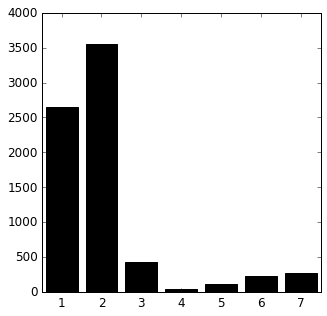

In [21]:
all_dataset_names = ["covtype", "iris", "make_classification"]

dataset_name = all_dataset_names[0]

if dataset_name == "covtype":
    dataset = fetch_covtype()
    data, target = dataset.data, dataset.target
    subsample_dataset = True
    make_binary = False
    subsample_interval = 80

elif dataset_name == "iris":
    dataset = load_iris()
    data, target = dataset.data, dataset.target
    subsample_dataset = False
    make_binary = False

elif dataset_name == "make_classification":
    data, target = make_classification(n_samples=10000, n_features=8,
                                       n_informative=6, n_redundant=2,
                                       n_classes=8,
                                       n_clusters_per_class=2,
                                       random_state=42)
    subsample_dataset = False
    make_binary = False

# densify
if scipy.sparse.issparse(data):
    print "Data is sparse! Attempting densification"
    data = data.toarray()

# Initially we have no missing
print "%0.2f %% of values missing" % (np.mean(np.isnan(target))*100)

print "The shape of the entire dataset - %s; Target - %s" % (str(data.shape), str(target.shape))
if subsample_dataset:
    #Subsample the data
    data, target = data[::subsample_interval], target[::subsample_interval]
    print "The shape of the subsampled dataset - %s" % str(data.shape)
    print

if make_binary:
    mask = target <= 2
    data, target = data[mask], target[mask]
    print "The shape of the binary dataset - %s" % str(data.shape)
    print

# Set the data_max and data_min vars
data_max = data.max() ** 2
data_min = data.min() ** 2


print "The maximum data value : %0.2f and minimum value : %0.2f" % (data_max, data_min)
print

labels = np.unique(target)
print "Labels -\t", labels
label_counts = np.bincount(target)[-len(labels):]
print "Label counts -\t", label_counts
print

labels_to_correlate_for_mnar = [1]

print "For MNAR case, the labels to correlate are - %s" % labels_to_correlate_for_mnar
print

print "The histogram of the label counts"

old_fig_size = plt.rcParams['figure.figsize'][:]
plt.rcParams['figure.figsize'][:] = [5, 5]
plt.bar(labels+0, label_counts, color='k', align='center')
plt.xlim([np.min(labels)-0.5, np.max(labels)+0.5])
plt.rcParams['figure.figsize'][:] = old_fig_size
plt.show()

#### Selectively Benchmark

In [46]:
# For the plot legend
est_labels = [
    'RF w/MV',                                # 0
    'IMP + RF',                               # 1
    'Missing max replaced + RF',              # 2
    'IMP + Dummy',                            # 3
    'IMP + Logit',                            # 4
    'XGB w/MV handled internally',            # 5
    'IMP + XGB',                              # 6
    'XGBs RF w/MV handled internally',        # 7
    'IMP + XGBs RF',                          # 8
    'RF w/MV with bootstrap True',            # 9
    'IMP + RF w/o MV with bootstrap True',    # 10
]  

# The estimators/techniques to run for benchmarking
bench_mask = [
#     0,
#     1,
#     2,
#     3,
#     4,
#     5,
#     6,
#     7,
#     8,
    9,
    10,
]

n_experiments_per_plot = 20
n_correlation_levels = 10

#### Some baseline scores

In [22]:
print ('The baseline score without missing (RF) is %0.8f'
       % cross_val_score(rf_miss_val, data, target, cv=cv).mean())

The baseline score without missing (RF) is 0.76753783


In [7]:
print ('The baseline score without missing (xgboost) is %0.8f'
       % cross_val_score(xgboost_miss_val, data, target, cv=cv).mean())

The baseline score without missing (xgboost) is 0.72365554


In [8]:
print ('The baseline score without missing (xgboost) is %0.8f'
       % cross_val_score(xgbrf_miss_val, data, target, cv=cv).mean())

The baseline score without missing (xgboost) is 0.82857470


#### The Benchmark

In [47]:
print 'The bench mask is %s' % bench_mask

missing_mask = np.zeros(data.shape, dtype=bool)
labels = None

label_1_fraction = np.mean(target==labels_to_correlate_for_mnar[0])
print label_1_fraction

label_correlations = np.linspace(0, 1, n_correlation_levels)
missing_fractions = ([np.linspace(0, 0.80, n_experiments_per_plot),] +
                     # Label 1 accounts of only around 35% of the samples
                     [np.linspace(0,
                                  0.9 * label_1_fraction,
                                  n_experiments_per_plot)]*(n_correlation_levels-1))
rng = np.random.RandomState(random_state)
                        
n_samples, n_features = data.shape
n_missing_fractions = list(map(len, missing_fractions))

n_experiments = len(label_correlations) * sum(n_missing_fractions)

# Intialize the scores and times with zeros
rf_miss_val_scores = np.zeros(n_experiments)
rf_impute_scores = np.zeros(n_experiments)
rf_max_min_scores = np.zeros(n_experiments)
dummy_impute_scores = np.zeros(n_experiments)
logit_impute_scores = np.zeros(n_experiments)
xgboost_impute_scores = np.zeros(n_experiments)
xgboost_miss_val_scores = np.zeros(n_experiments)
xgbrf_miss_val_scores = np.zeros(n_experiments)
xgbrf_impute_scores = np.zeros(n_experiments)
rf_miss_val_btstrp_scores = np.zeros(n_experiments)
rf_impute_btstrp_scores = np.zeros(n_experiments)

rf_miss_val_times = np.zeros(n_experiments)
rf_impute_times = np.zeros(n_experiments)
rf_max_min_times = np.zeros(n_experiments)
dummy_impute_times = np.zeros(n_experiments)
logit_impute_times = np.zeros(n_experiments)
xgboost_impute_times = np.zeros(n_experiments)
xgboost_miss_val_times = np.zeros(n_experiments)
xgbrf_miss_val_times = np.zeros(n_experiments)
xgbrf_impute_times = np.zeros(n_experiments)
rf_miss_val_btstrp_times = np.zeros(n_experiments)
rf_impute_btstrp_times = np.zeros(n_experiments)

experiment_i = -1
print "The bench_mask", bench_mask
for i, label_correlation in enumerate(label_correlations):
    print "Labels correlated with - %s" % str(labels)
    print "Label correlation - %0.2f" % label_correlation
    print
    
    X, y = data.copy(), target.copy()
    missing_mask = np.zeros(X.shape, dtype=bool)
    labels = labels_to_correlate_for_mnar
        
    for j, missing_fraction in enumerate(missing_fractions[i]):
        print
        print "-------------------------------------------------------"
        
        """
        # Old way of generating missing data --------------------------
        rv = rng.randn(*X.shape)
        rv = rng.randn(*X.shape)
        thresh = np.sort(rv.ravel())[int(missing_fraction * n_samples * n_features)]
        missing_mask += rv < thresh
        if label_correlation == 1:  # MNAR
            missing_mask[y!=labels[0]] = False  # Features should go missing only for y=1
        X[missing_mask] = np.nan
        # -------------------------------------------------------------
        """
        
        # Generate the missing values using the `drop_values` function
        X, y, missing_mask, label = drop_values(
            X, y,
            missing_mask=missing_mask,
            missing_fraction=missing_fraction,
            # The MCAR-ness should not change
            label_correlation=label_correlation,
            # Persist the correlation with the same label
            labels=labels,
            return_missing_mask=True,
            return_labels=True,
            random_state=random_state,
            )
        
        print ("Missing fraction - (Expected - %0.4f, Actual - %0.4f)"
               % (missing_fraction, missing_mask.mean()))
        print ("Fraction of samples missing when label == %d - %0.4f"
               % (labels[0], missing_mask[y==labels[0]].mean()))
        print ("Fraction of samples missing when label != %d - %0.4f"
               % (labels[0], missing_mask[y!=labels[0]].mean()))
        print "-------------------------------------------------------"
        
        experiment_i += 1
        
        # RF w/MV
        if 0 in bench_mask:
            start = timer()
            rf_miss_val_scores[experiment_i] = (
                cross_val_score(rf_miss_val, X, y, cv=cv).mean())
            rf_miss_val_times[experiment_i] = timer() - start
            print ("RF w/MV completed in %0.2f s with a mean score of %0.4f"
                   % (rf_miss_val_times[experiment_i],
                      rf_miss_val_scores[experiment_i]))
        
        # IMP + RF
        if 1 in bench_mask:
            start = timer()
            rf_impute_scores[experiment_i] = (
                cross_val_score(rf_impute, X, y, cv=cv).mean())
            rf_impute_times[experiment_i] = timer() - start
            print ("IMP + RF completed in %0.2f s with a mean score of %0.4f"
                   % (rf_impute_times[experiment_i],
                      rf_impute_scores[experiment_i]))
            print
        
        # X replaced + RF
        if 2 in bench_mask:
            # Replace X's nan with data_max/data_min
            X[missing_mask] = data_max
            start = timer()
            rf_max_min_scores[experiment_i] = (
                cross_val_score(rf_max_min, X, y, cv=cv).mean())
            rf_max_min_times[experiment_i] = timer() - start
            # Revert the change
            X[missing_mask] = np.nan
            print ("Missing replaced + RF completed in %0.2f s with a mean score of %0.4f"
                   % (rf_max_min_times[experiment_i],
                      rf_max_min_scores[experiment_i]))
        
        # IMP + Dummy
        if 3 in bench_mask:
            start = timer()
            dummy_impute_scores[experiment_i] = (
                cross_val_score(dummy_impute, X, y, cv=cv).mean())
            dummy_impute_times = timer() - start
            print ("IMP + Dummy completed in %0.2f s with a mean score of %0.4f"
                   % (dummy_impute_times[experiment_i],
                      dummy_impute_scores[experiment_i]))
            print


        # IMP + Logistic Regression
        if 4 in bench_mask:
            start = timer()
            logit_impute_scores[experiment_i] = (
                cross_val_score(logit_impute, X, y, cv=cv).mean())
            logit_impute_times[experiment_i] = timer() - start
            print ("IMP + Logit completed in %0.2f s with a mean score of %0.4f"
                   % (logit_impute_times[experiment_i],
                      logit_impute_scores[experiment_i]))
            print

        # XGB's GB w/MV
        if 5 in bench_mask:
            start = timer()
            xgboost_miss_val_scores[experiment_i] = (
                cross_val_score(xgboost_miss_val, X, y, cv=cv).mean())
            xgboost_miss_val_times = timer() - start
            print ("XGBoost w/miss val handled internally completed in %0.2f s "
                   "with a mean score of %0.4f"
                   % (xgboost_miss_val_times[-1], xgboost_miss_val_scores[-1]))        
        
        # Imp + XGB's GB
        if 6 in bench_mask:
            start = timer()
            xgboost_impute_scores[experiment_i] = (
                cross_val_score(xgboost_impute, X, y, cv=cv).mean())
            xgboost_impute_times = timer() - start
            print ("Imp + XGBoost GB completed in %0.2f s"
                   "with a mean score of %0.4f"
                   % (xgboost_impute_times[experiment_i],
                      xgboost_impute_scores[experiment_i]))        
            print
                                     
        # XGB's RF w/MV
        if 7 in bench_mask:
            start = timer()
            xgbrf_miss_val_scores[experiment_i] = (
                cross_val_score(xgbrf_miss_val, X, y, cv=cv).mean())
            xgbrf_miss_val_times[experiment_i] = timer() - start
            print ("XGBoosts RF  w/miss val handled internally completed"
                   " in %0.2f s with a mean score of %0.4f"
                   % (xgbrf_miss_val_times[experiment_i],
                      xgbrf_miss_val_scores[experiment_i]))

        # Imp + XGB's RF
        if 8 in bench_mask:
            start = timer()
            xgbrf_impute_scores[experiment_i] = (
                cross_val_score(xgbrf_impute, X, y, cv=cv).mean())
            xgbrf_impute_times[experiment_i] = timer() - start
            print ("Imp + XGBoosts RF completed in %0.2f s with a mean score of %0.4f"
                   % (xgbrf_impute_times[experiment_i],
                      xgbrf_impute_scores[experiment_i]))
            print
            
        # RF w/MV and bootstrap set to True
        if 9 in bench_mask:
            start = timer()
            rf_miss_val_btstrp_scores[experiment_i] = (
                cross_val_score(rf_miss_val_btstrp, X, y, cv=cv).mean())
            rf_miss_val_btstrp_times[experiment_i] = timer() - start
            print ("RF w/MV w/bootstrap completed in %0.2f s with a mean score of %0.4f"
                   % (rf_miss_val_btstrp_times[experiment_i],
                      rf_miss_val_btstrp_scores[experiment_i]))
        
        # IMP + RF w boostrap set to True
        if 10 in bench_mask:
            start = timer()
            rf_impute_btstrp_scores[experiment_i] = (
                cross_val_score(rf_impute_btstrp, X, y, cv=cv).mean())
            rf_impute_btstrp_times[experiment_i] = timer() - start
            print ("IMP + RF w/bootstrap completed in %0.2f s with a mean score of %0.4f"
                   % (rf_impute_btstrp_times[experiment_i],
                      rf_impute_btstrp_scores[experiment_i]))

        print "-------------------------------------------------------"

The bench mask is [9, 10]
0.365413740878
The bench_mask [9, 10]
Labels correlated with - None
Label correlation - 0.00


-------------------------------------------------------
No of (additional) correlated/uncorrelated missing values - 0/0
Missing fraction - (Expected - 0.0000, Actual - 0.0000)
Fraction of samples missing when label == 1 - 0.0000
Fraction of samples missing when label != 1 - 0.0000
-------------------------------------------------------
RF w/MV w/bootstrap completed in 1.89 s with a mean score of 0.7762
IMP + RF w/bootstrap completed in 1.96 s with a mean score of 0.7762
-------------------------------------------------------

-------------------------------------------------------
No of (additional) correlated/uncorrelated missing values - 0/16513
Missing fraction - (Expected - 0.0421, Actual - 0.0421)
Fraction of samples missing when label == 1 - 0.0419
Fraction of samples missing when label != 1 - 0.0422
-------------------------------------------------------
RF w/

#### Score/Time plot mask

In [48]:
# For the plot legend
est_labels = [
    'RF w/MV with no bootstrap',                               # 0
    'IMP + RF with no bootstrap',                              # 1
    'Missing max replaced + RF (with btstrp)',                 # 2
    'IMP + Dummy',                                             # 3
    'IMP + Logit',                                             # 4
    'XGB w/MV handled internally',                             # 5
    'IMP + XGB',                                               # 6
    'XGBs RF w/MV handled internally',                         # 7
    'IMP + XGBs RF',                                           # 8
    'RF w/MV with bootstrap',                                  # 9
    'IMP + RF w/o MV with bootstrap',                          # 10
]            

# The estimators/techniques for the score plots
score_plot_mask =  [
#     0,
#     1,
#     2,
#     3,
#     4,
#     5,
#     6,
#     7,
#     8,
    9,
    10,
]

# The estimators/techniques for the time plots
time_plot_mask =  [
#     0,
#     1,
#     2,
#     3,
#     4,
#     5,
#     6,
#     7,
#     8,
    9,
    10,
]

#### Plotting the results

Labels correlated with - [1]
Label correlation - 0.00

Plotting the benchmark scores and times when label_correlation is 0.00. n_estimators=50
dataset - covtype. data shape - (7263, 54).


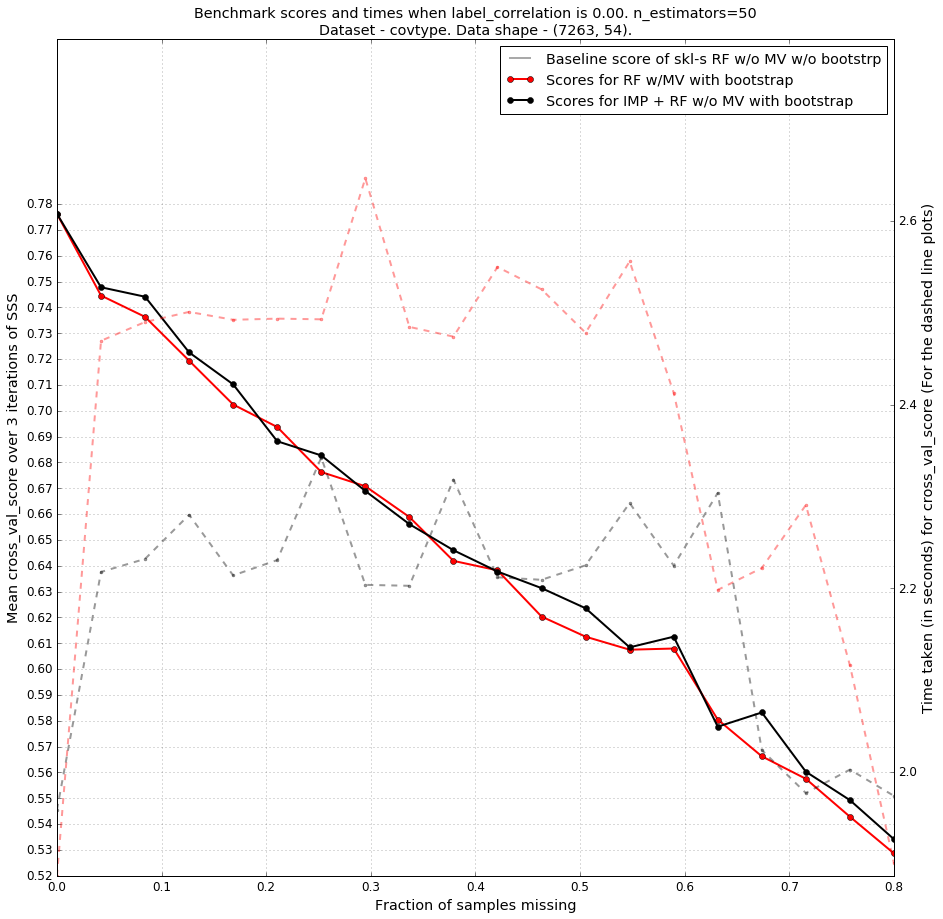

Label correlation - 0.11

Plotting the benchmark scores and times when label_correlation is 0.11. n_estimators=50
dataset - covtype. data shape - (7263, 54).


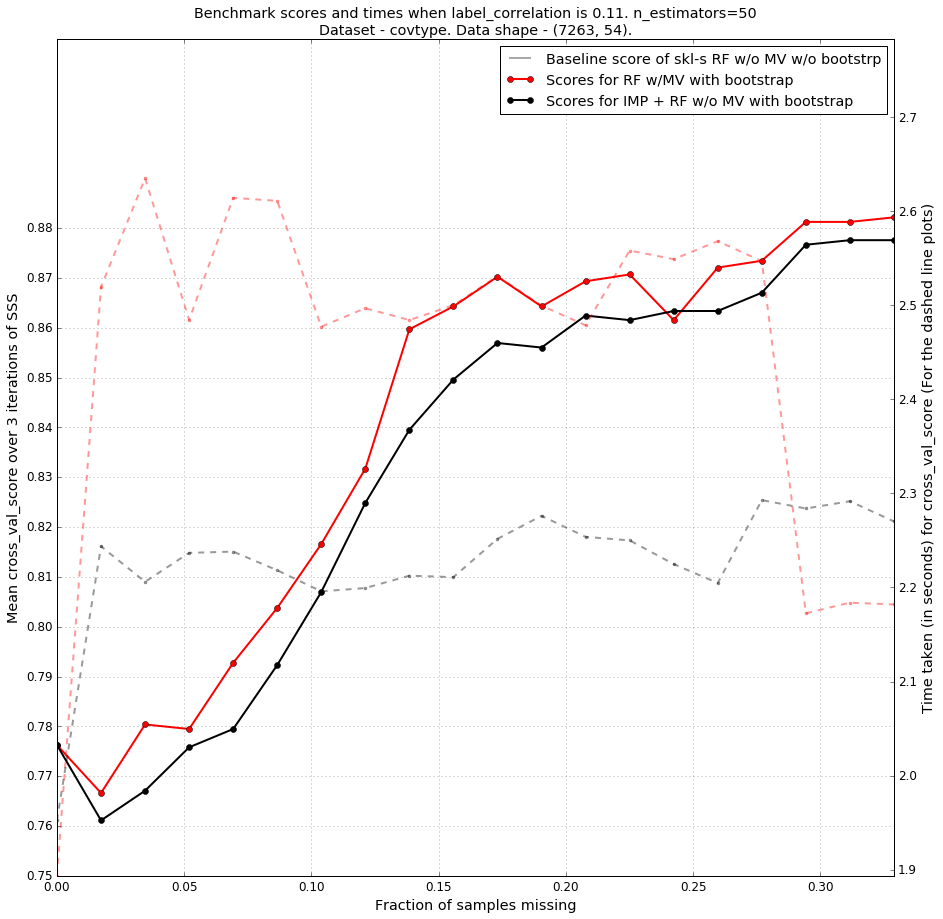

Label correlation - 0.22

Plotting the benchmark scores and times when label_correlation is 0.22. n_estimators=50
dataset - covtype. data shape - (7263, 54).


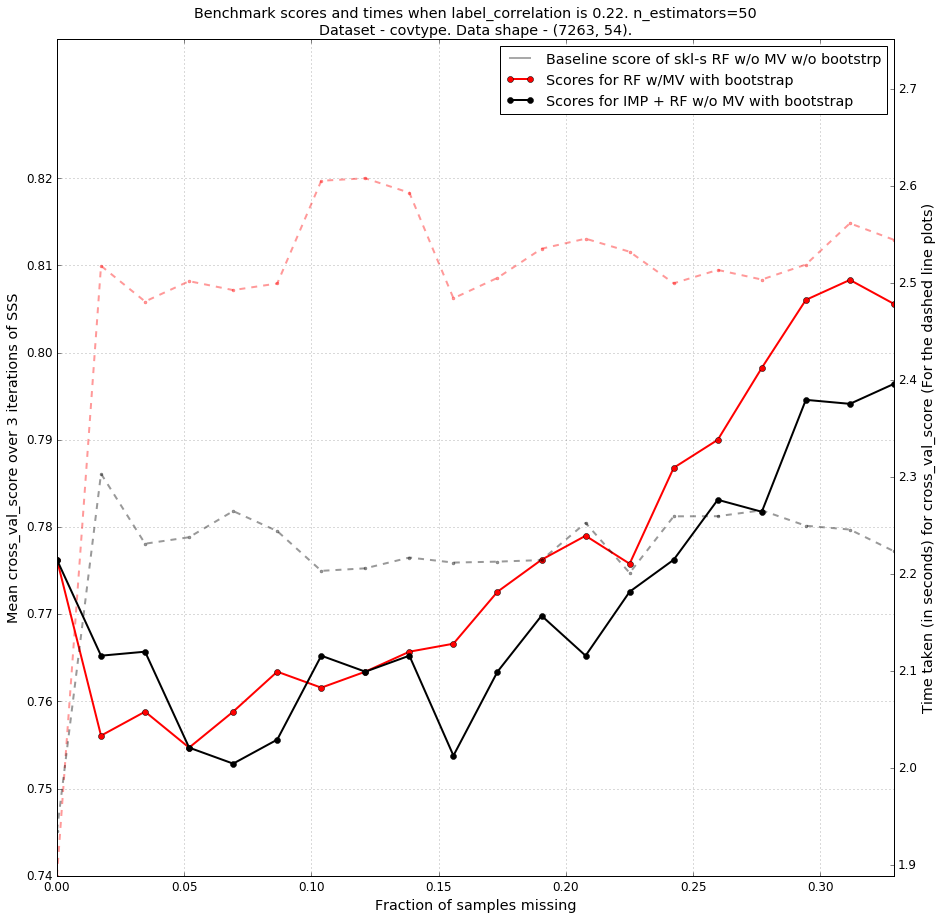

Label correlation - 0.33

Plotting the benchmark scores and times when label_correlation is 0.33. n_estimators=50
dataset - covtype. data shape - (7263, 54).


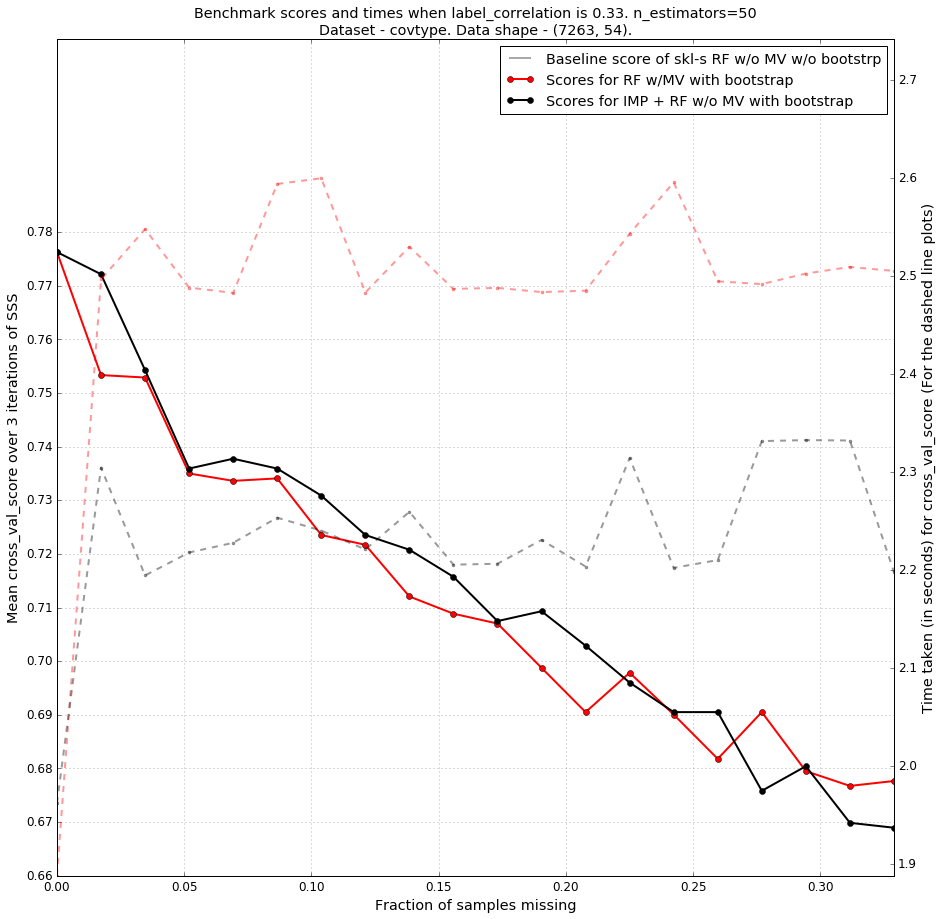

Label correlation - 0.44

Plotting the benchmark scores and times when label_correlation is 0.44. n_estimators=50
dataset - covtype. data shape - (7263, 54).


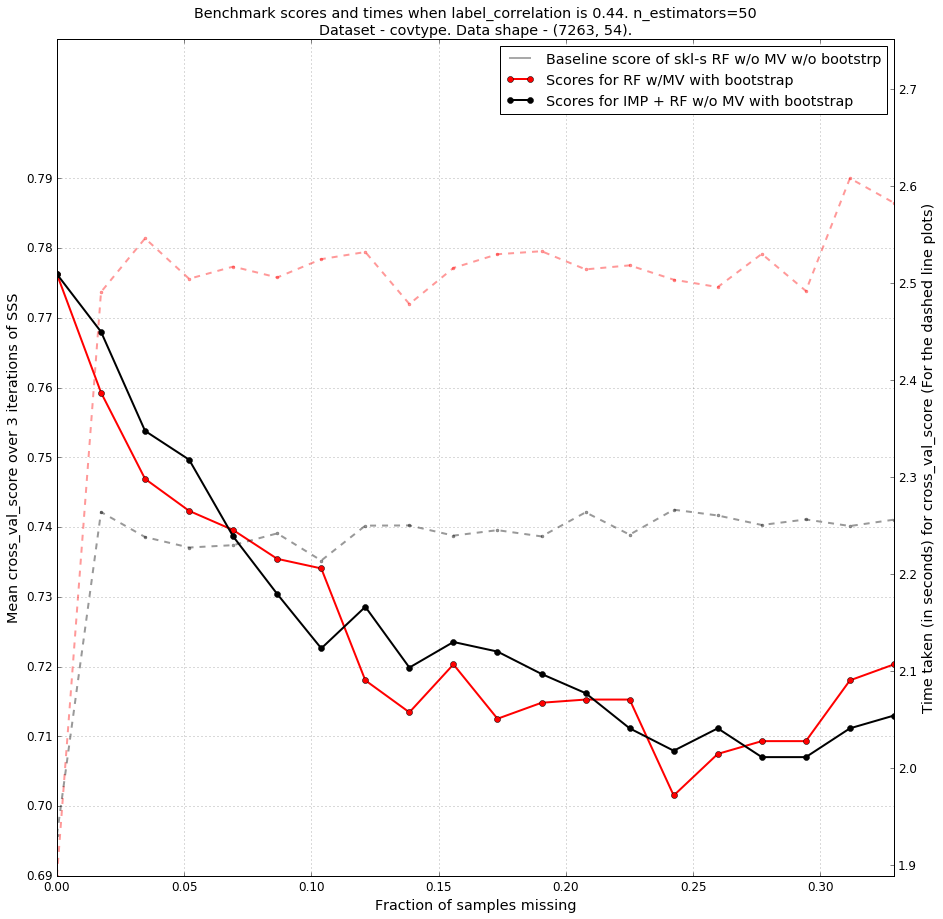

Label correlation - 0.56

Plotting the benchmark scores and times when label_correlation is 0.56. n_estimators=50
dataset - covtype. data shape - (7263, 54).


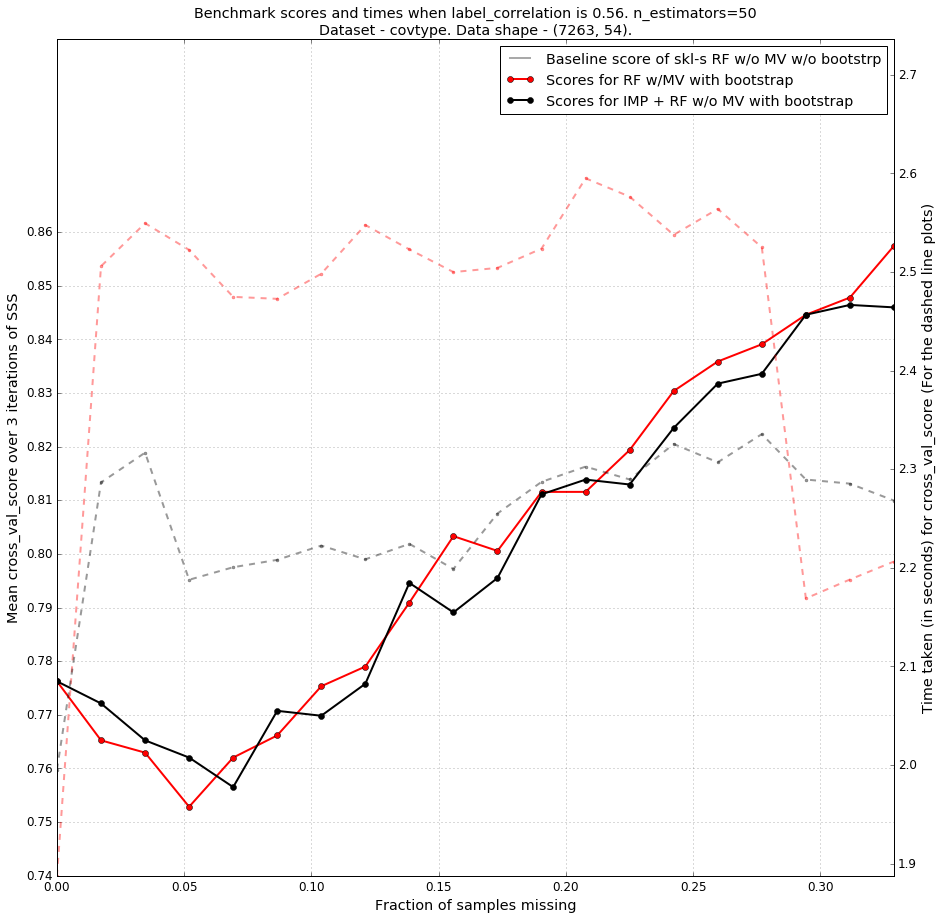

Label correlation - 0.67

Plotting the benchmark scores and times when label_correlation is 0.67. n_estimators=50
dataset - covtype. data shape - (7263, 54).


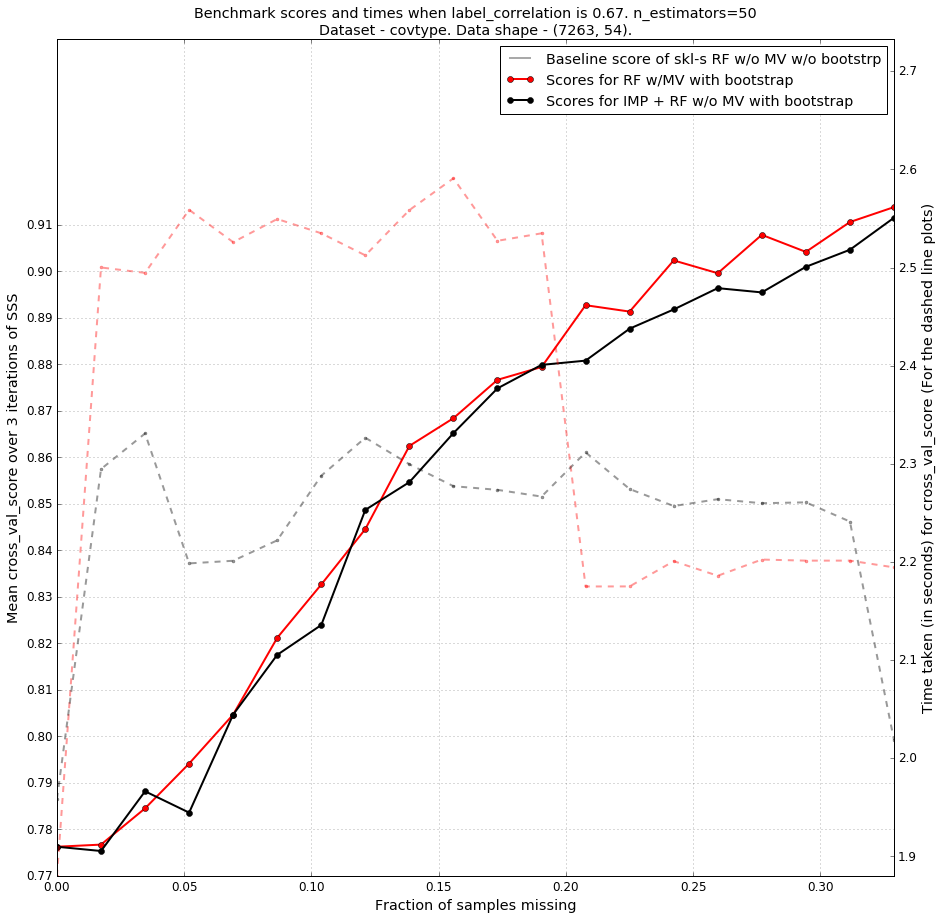

Label correlation - 0.78

Plotting the benchmark scores and times when label_correlation is 0.78. n_estimators=50
dataset - covtype. data shape - (7263, 54).


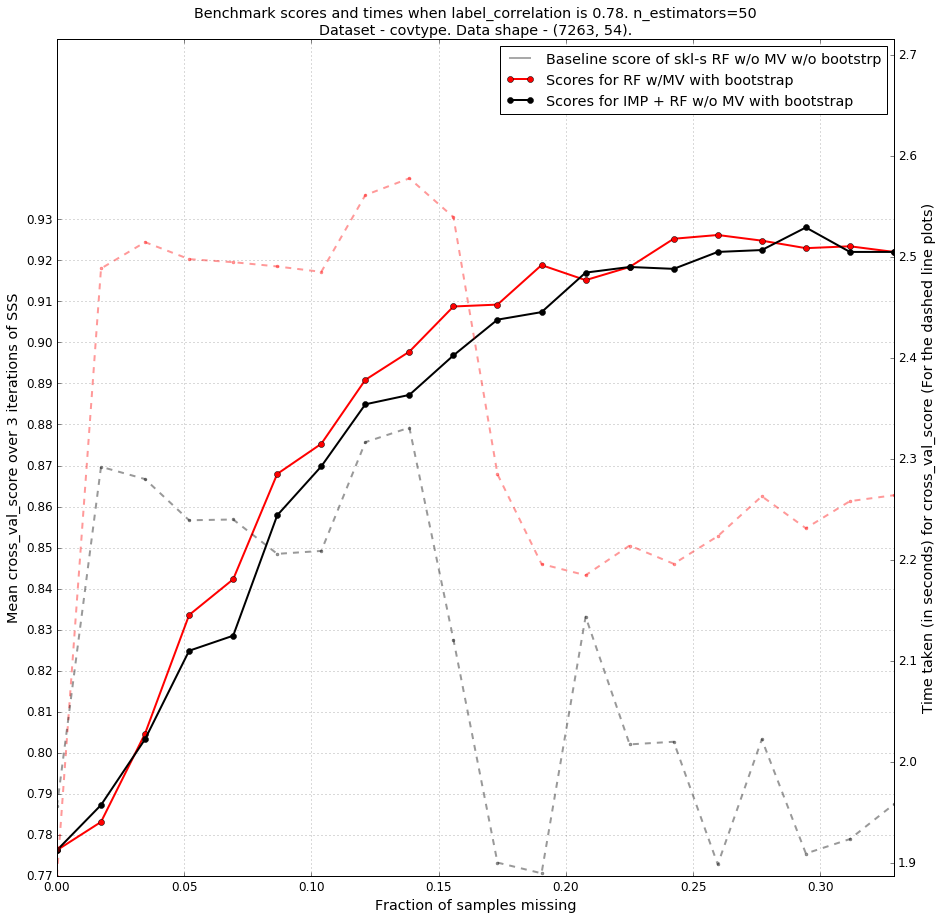

Label correlation - 0.89

Plotting the benchmark scores and times when label_correlation is 0.89. n_estimators=50
dataset - covtype. data shape - (7263, 54).


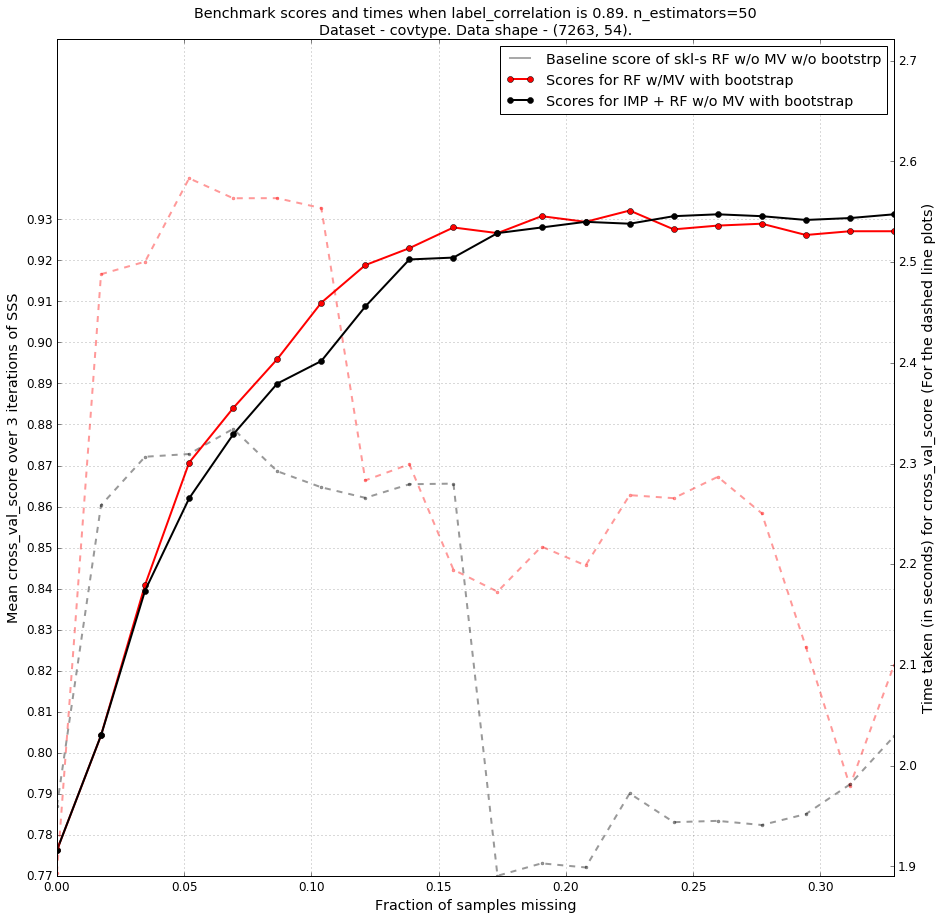

Label correlation - 1.00

Plotting the benchmark scores and times when label_correlation is 1.00. n_estimators=50
dataset - covtype. data shape - (7263, 54).


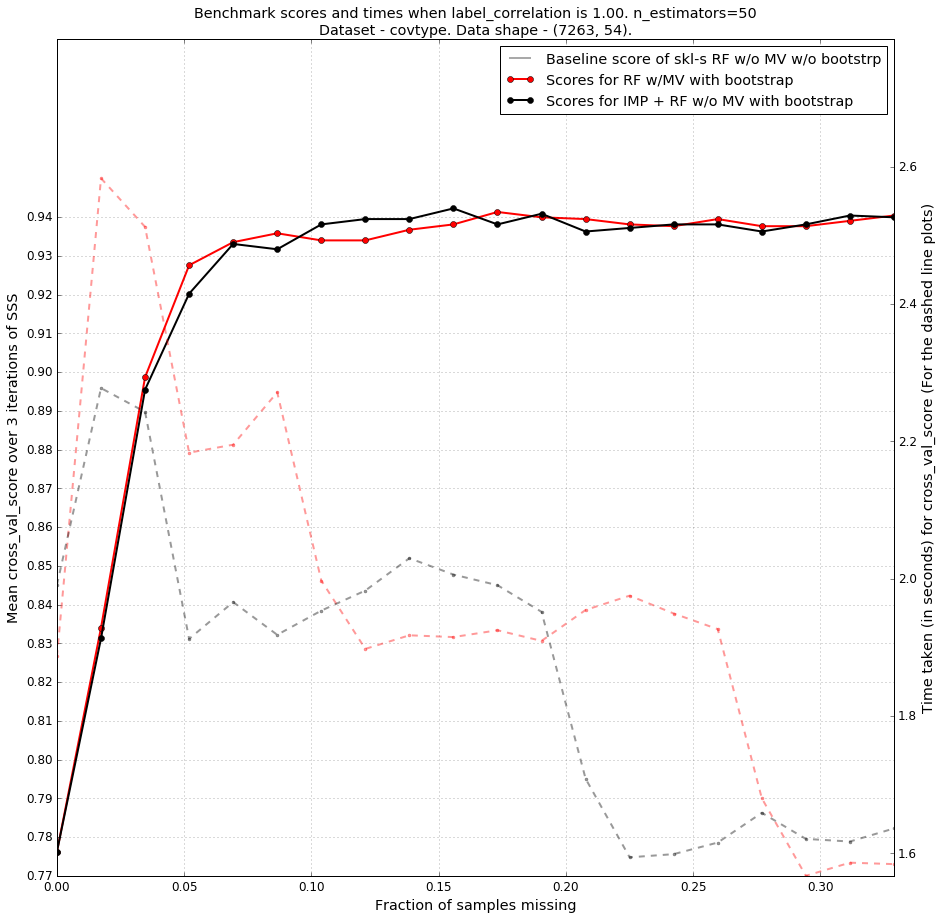

In [49]:
# Plot the scores and times
index = 0
if label_correlation != 0:
        print "Labels correlated with - %s" % str(labels)

# For the score plot
plot_colors = ['olive', 'lightpink', 'g', 'b', 'yellow', 'brown', 'm',
               'cyan', 'lime', 'r', 'k']

for idx, label_correlation in enumerate(label_correlations):
    print "Label correlation - %0.2f" % label_correlation
    print
    
    title = ("Benchmark scores and times when label_correlation is %0.2f. n_estimators=%d"
             % (label_correlation, n_estimators))
    title += "\nDataset - %s. Data shape - %s." % (dataset_name, str(data.shape))
    print "Plotting the", title.lower()
    
    current_slice = range(index, index + n_missing_fractions[idx])
    index += n_missing_fractions[idx]
    
    all_scores = np.array([
        rf_miss_val_scores[current_slice],
        rf_impute_scores[current_slice],
        rf_max_min_scores[current_slice],
        dummy_impute_scores[current_slice],
        logit_impute_scores[current_slice],
        xgboost_miss_val_scores[current_slice],
        xgboost_impute_scores[current_slice],
        xgbrf_miss_val_scores[current_slice],
        xgbrf_impute_scores[current_slice],
        rf_miss_val_btstrp_scores[current_slice],
        rf_impute_btstrp_scores[current_slice],
        ])

    all_times = np.array([
        rf_miss_val_times[current_slice],
        rf_impute_times[current_slice],
        rf_max_min_times[current_slice],
        dummy_impute_times[current_slice],
        logit_impute_times[current_slice],
        xgboost_miss_val_times[current_slice],
        xgboost_impute_times[current_slice],
        xgbrf_miss_val_times[current_slice],
        xgbrf_impute_times[current_slice],
        rf_miss_val_btstrp_times[current_slice],
        rf_impute_btstrp_times[current_slice],
    ])
    
    #print missing_fractions[idx]
    #print current_slice
    fig, ax1 = plt.subplots()
    # Get the right y axis for time plot
    ax2 = ax1.twinx()

    # A straight line for the baseline score
    # The first score is computed with no missing values
    l1 = ax1.axhline(all_scores[0][0], label='Baseline score of skl-s RF w/o MV w/o bootstrp',
                     color='darkgrey', linewidth=2)
    
    for i, scores in enumerate(all_scores):
        # print i
        if i in score_plot_mask:
            l2 = ax1.plot(missing_fractions[idx], scores,
                          'o-',
                          color=plot_colors[i],
                          label="Scores for %s" % est_labels[i],
                          linewidth=2)

    for i, times in enumerate(all_times):
        # print i
        if i in time_plot_mask:
            l3 = ax2.plot(missing_fractions[idx], times,
                          '.--',
                          color=plot_colors[i],
                          linewidth=2,
                          alpha=0.4)    

    # Compute the axis extremes, to position the legend cleanly
    score_decimals = 2
    min_score = np.round(np.min(all_scores[score_plot_mask][all_scores[score_plot_mask]!=0]),
                         score_decimals) - 0.1**score_decimals
    max_score = np.round(np.max(all_scores[score_plot_mask]),
                         score_decimals)+0.1**score_decimals
    
    score_space_for_legend = (max_score - min_score) / 5.
    
    min_time = np.min(all_times[time_plot_mask][all_times[time_plot_mask]!=0])
    max_time = np.max(all_times[time_plot_mask])
    
    time_space_for_legend = (max_time - min_time) / 5.
    
    ax1.set_xlim([missing_fractions[idx][0], missing_fractions[idx][-1]])
    ax1.set_ylim([min_score, max_score + score_space_for_legend])
    ax1.set_yticks(np.arange(min_score, max_score, 0.1**score_decimals))
    ax1.set_ylabel('Mean cross_val_score over 3 iterations of SSS')
    ax1.grid(True, alpha=0.6)
    
    ax2.set_ylabel('Time taken (in seconds) for cross_val_score (For the dashed line plots)')
    ax2.set_ylim([min_time, max_time + time_space_for_legend])
    
    ax1.legend(loc=1)
    # ax2.grid(True)
    # ax2.legend(loc='best')
    
    # plt.legend(loc='best')
    
    ax1.set_xlabel("Fraction of samples missing")    
    plt.title(title)    
    plt.show()

In [12]:
X = np.array([[0, 2, 3],
              [6, 8, 5],
              [2, 3, 4],
              [5, 6, 7],
              [8, 8, 8],
              [8, 8, 8],
              [8, 8, 8],
              [8, 8, 8],
              [9, 8, 8],
              [10, 0, 1]], dtype=np.float)

y = np.array([1, 1, 0, 0, 2, 2, 2, 2, 2, 2])

mm = np.isnan(X)

X, y, mm = drop_values(X, y, missing_mask=mm, missing_fraction=0.1,
                       labels=[1], label_correlation=0.75,
                       return_missing_mask=True,
                       random_state=42)

print X, mm.mean()

No of (additional) correlated/uncorrelated missing values - 2/1
[[ nan  nan   3.]
 [  6.   8.   5.]
 [  2.   3.   4.]
 [  5.   6.   7.]
 [  8.   8.   8.]
 [  8.   8.   8.]
 [  8.   8.   8.]
 [  8.   8.   8.]
 [  9.  nan   8.]
 [ 10.   0.   1.]] 0.1


In [13]:
missing_mask[y!=1].mean()

/cal/homes/vrajagopalan/.local/lib/python2.7/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 29051 but corresponding boolean dimension is 10
  if __name__ == '__main__':


0.4375

In [14]:
drop_values(data, target, missing_fraction=0.0,
            missing_mask=mm,
            return_missing_mask=True)

ValueError: There are currently 3 missing values, which is >= a fraction of 0.00 that isexpected to be missing.

In [ ]:
#rf_with_impute.fit(data, target)

#rf_missing_val.estimators_[0]

import matplotlib.pyplot as plt
import pygraphviz as pgv
import networkx as nx
import pygraphviz
import matplotlib.image as img
import matplotlib.pyplot as plt

from sklearn.tree import export_graphviz
from StringIO import StringIO
from io import BytesIO

def get_graph(dtc, n_classes, feat_names=None, size=[7, 7], max_depth=10):
    dot_file = StringIO()
    image_file = BytesIO()

    # Get the dot graph of our decision tree
    export_graphviz(dtc, out_file=dot_file, feature_names=feat_names,
                    rounded=True, filled=True,
                    special_characters=True,
                    class_names=map(str, range(1, n_classes+1)),
                    max_depth=max_depth)
    dot_file.seek(0)

    # Convert this dot graph into an image
    g = pygraphviz.AGraph(dot_file.read())
    g.layout('dot')
    # g.draw doesn't work when the image object doesn't have a name (with a proper extension)
    image_file.name = "image.png"
    image_file.seek(0)
    g.draw(path=image_file)
    image_file.seek(0)

    # Plot it
    plt.figure().set_size_inches(*size)
    plt.axis('off')
    plt.imshow(img.imread(fname=image_file))
    plt.show()

In [ ]:
X[:, 0].size

In [ ]:
#dtc = rf_with_impute.steps[1][1].estimators_[0]
#dtc2= rf_miss_val.estimators_[4]
print np.isnan(X).mean(), missing_mask.mean()
print X.shape

In [ ]:
dtc = DecisionTreeClassifier(random_state=0, missing_values='NaN')
#dtc = rf_miss_val.fit(X, y).estimators_[1]
dtc.fit(X, y)

In [ ]:
get_graph(dtc, n_classes=len(np.unique(y)),
          feat_names=np.arange(X.shape[1]), size=[100, 200], max_depth=4)

In [ ]:
rf_miss_val

In [ ]:
baseline_score = np.load('baseline_score.npy')
missing_fraction_range = np.load('missing_fraction_range.npy')
scores_missing = np.load('scores_missing.npy')
scores_impute = np.load('scores_impute.npy')

In [ ]:
plt.close('all')
plt.plot(missing_fraction_range, seconds_missing, '.--', color='r', label='RF MV enabled')
plt.plot(missing_fraction_range, seconds_impute, '.--', color='b', label='RF+imputer')
plt.axhline(35, label='RF w/No missing', color='k')
#for sample_pt in missing_fraction_range:
#    plt.axvline(sample_pt, linestyle='--', color='g')
plt.xlabel('Missing fraction')
plt.ylabel('Time taken for cross_val_score using 3 iterations of StratifiedShuffleSplit in seconds')
plt.legend(loc='best')
plt.show()

In [ ]:
from sklearn.datasets import fetch_mldata

adult = fetch_mldata('yeast')

In [ ]:
cat_feats = np.load('cat_feats.npy').tolist()
feat_names = np.load('feat_names.npy').tolist()
data = np.load('data.npy')
target = np.load('target.npy')

#### Debugging missing value support

In [ ]:
# Toy data which will send all the missing values to the right at the root node
%matplotlib inline

import numpy as np
from sklearn.tree import DecisionTreeClassifier

X = np.array(
        [[np.nan],
         [np.nan],
         [np.nan],
         [np.nan],
         [0],
         [1],
         [2],
         [3],
         [12],
         [13],
         [10],
         [11],
         [12],
         [13],
         [14]])

y = np.array([1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])

In [ ]:
get_graph(DecisionTreeClassifier(missing_values='NaN').fit(X, y),
          n_classes=3, size=(7, 7))

In [ ]:
# coding: utf-8
# pylint: disable=too-many-arguments, too-many-locals, invalid-name, fixme
"""Scikit-Learn Wrapper interface for XGBoost."""
from __future__ import absolute_import

import numpy as np
from xgboost.core import Booster, DMatrix, XGBoostError
from xgboost.training import train

from xgboost.compat import (SKLEARN_INSTALLED, XGBModelBase,
                            XGBClassifierBase, XGBRegressorBase, LabelEncoder)



In [ ]:
train?

In [ ]:
xgbrf = XGBRFClassifier(n_estimators=n_estimators,
                        nthread=n_jobs,
                        max_depth=100,
                        missing=np.nan,
                        objective='multiclass:logistic',
                        subsample=0.6,
                        seed=random_state,
                        base_score=0)

In [ ]:
cross_val_score(xgbrf, data, target, cv=cv, fit_params={'eval_metric': 'auc'})

In [ ]:
xgbrf

In [ ]:
rf_miss_val

In [ ]:
train?